In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from utils.audio import print_stats, plot_waveform, plot_specgram, play_audio, plot_spectrogram

print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
print(f"torchaudio {torchaudio.__version__}")

Using torch 1.9.1 (NVIDIA GeForce RTX 3060 Laptop GPU)
torchaudio 0.9.0a0+a85b239


In [2]:
audio_path = '4-7.mp3'
label = 'but it was only later that i found out'

metadata = torchaudio.info(audio_path)
print(metadata)

waveform, sample_rate = torchaudio.load(audio_path)
waveform = torch.mean(waveform, dim=0).unsqueeze(0) # reduce channels to one
signal = waveform # [:, 0:int(3 * sample_rate)] take 3 seconds


AudioMetaData(sample_rate=44100, num_frames=84055, num_channels=2, bits_per_sample=0, encoding=MP3)


Sample Rate: 44100
Shape: (1, 84055)
Dtype: torch.float32
 - Max:          0.523
 - Min:         -0.319
 - Mean:        -0.000
 - Std Dev:      0.081

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0062, -0.0088, -0.0118]])



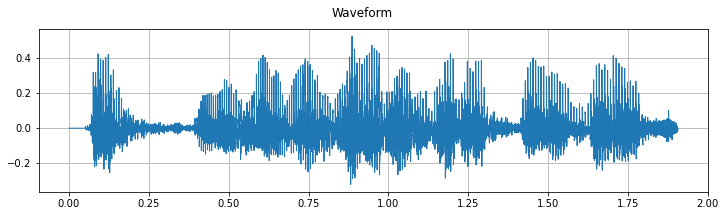

/home/xunwei/miniconda3/envs/asr/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


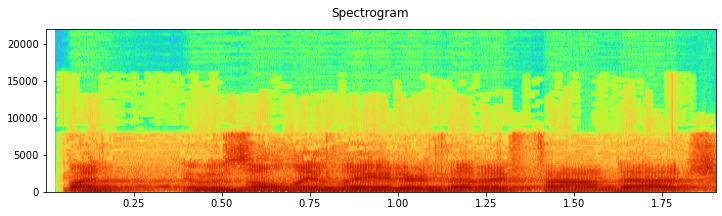

In [3]:
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

### [Kaldi](https://pytorch.org/audio/stable/compliance.kaldi.html#)

``` python
torchaudio.compliance.kaldi.fbank(waveform: torch.Tensor, blackman_coeff: float = 0.42, channel: int = - 1, dither: float = 0.0, 
                                  energy_floor: float = 1.0, frame_length: float = 25.0, frame_shift: float = 10.0, 
                                  high_freq: float = 0.0, htk_compat: bool = False, low_freq: float = 20.0, 
                                  min_duration: float = 0.0, num_mel_bins: int = 23, preemphasis_coefficient: float = 0.97, 
                                  raw_energy: bool = True, remove_dc_offset: bool = True, round_to_power_of_two: bool = True, 
                                  sample_frequency: float = 16000.0, snip_edges: bool = True, subtract_mean: bool = False, 
                                  use_energy: bool = False, use_log_fbank: bool = True, use_power: bool = True, 
                                  vtln_high: float = - 500.0, vtln_low: float = 100.0, vtln_warp: float = 1.0, 
                                  window_type: str = 'povey')
```

``` python
torchaudio.compliance.kaldi.mfcc(waveform: torch.Tensor, blackman_coeff: float = 0.42, cepstral_lifter: float = 22.0, 
                                channel: int = -1, dither: float = 0.0, energy_floor: float = 1.0, frame_length: float = 25.0, 
                                frame_shift: float = 10.0, high_freq: float = 0.0, htk_compat: bool = False, 
                                low_freq: float = 20.0, num_ceps: int = 13, min_duration: float = 0.0, num_mel_bins: int = 23, 
                                preemphasis_coefficient: float = 0.97, raw_energy: bool = True, remove_dc_offset: bool = True, 
                                round_to_power_of_two: bool = True, sample_frequency: float = 16000.0, snip_edges: bool = True, 
                                subtract_mean: bool = False, use_energy: bool = False, vtln_high: float = -500.0, 
                                vtln_low: float = 100.0, vtln_warp: float = 1.0, window_type: str = 'povey')
```

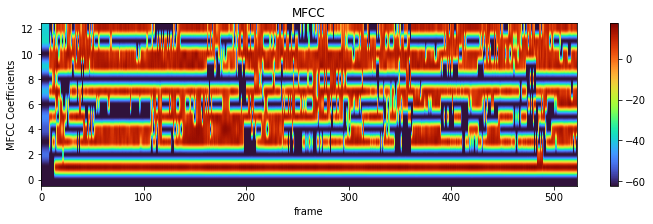

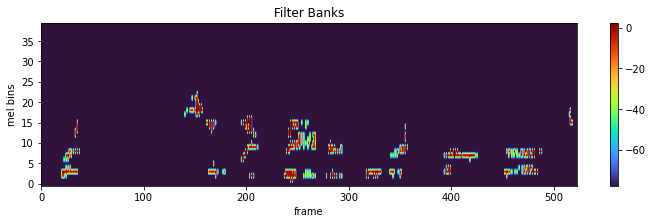

In [4]:
feat_dim = 13
waveform_trans = torchaudio.compliance.kaldi.mfcc(signal, frame_length=25, frame_shift=10, num_mel_bins=feat_dim)
plot_spectrogram(waveform_trans.transpose(0, 1).detach(), title="MFCC", ylabel='MFCC Coefficients')

# currently using fbanks for project
feat_dim = 40
waveform_trans = torchaudio.compliance.kaldi.fbank(signal, frame_length=25, frame_shift=10, num_mel_bins=feat_dim)
plot_spectrogram(waveform_trans.transpose(0, 1).detach(), title="Filter Banks", ylabel='mel bins')

### Experiment downsampling

In [5]:
feature = waveform_trans
feat_len = feature.shape[0] # the longest feat_len of batch

# test downsampling methods
# crop so end divisible by 4
print('feat', feature.shape)
if feature.shape[0] % 4 != 0:
    cropped_feat = feature[:-(feature.shape[0] % 4), :].contiguous().shape
print('cropped_feat', cropped_feat)

feat torch.Size([523, 40])
cropped_feat torch.Size([520, 40])


torch.Size([130, 40])


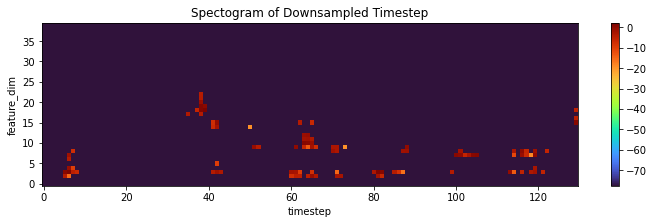

In [6]:
feat_len = torch.div(feat_len, 4, rounding_mode='floor') # the longest feat_len in list of timestep, just taking one example here

# downsample
sample_rate = 4
if feature.shape[0] % 4 != 0:
    output = feature[:-(feature.shape[0] % 4), :].contiguous()
output = output[::sample_rate, :].contiguous()
print(output.shape)
plot_spectrogram(output.transpose(0, 1), title='Spectogram of Downsampled Timestep', xlabel='timestep', ylabel='feature_dim')

### Extractor

In [7]:
import sys
sys.path.append('../')
from src.extractor import *
from src.classifier import *
from src.module import *

feat_len = torch.tensor([523, 123])
waveform_trans = waveform_trans[:125, :]
feature = torch.stack((waveform_trans, waveform_trans),dim=0)
feature.shape

torch.Size([2, 125, 40])

640
torch.Size([2, 31, 640]) tensor([130,  30])


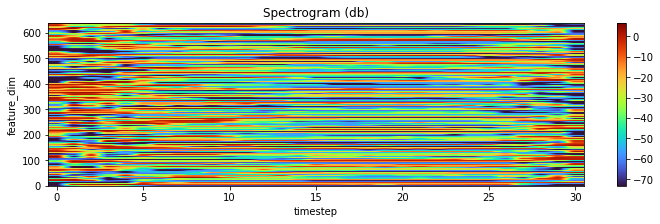

In [8]:
net = ANNExtractor(40)
print(net.out_dim)
out_feature, out_feat_len = net(feature, feat_len)
print(out_feature.shape, out_feat_len)
plot_spectrogram(out_feature[0].transpose(0, 1).detach(), xlabel='timestep', ylabel='feature_dim')

1280
torch.Size([2, 31, 1280]) tensor([130,  30])


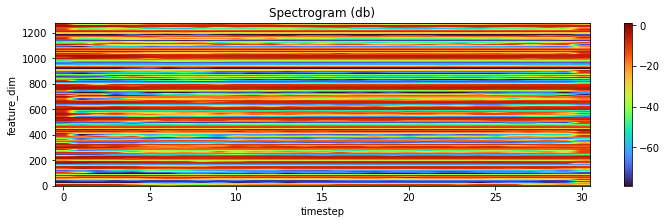

In [9]:
net = VGGExtractor(40)
print(net.out_dim)
out_feature, out_feat_len = net(feature, feat_len)
print(out_feature.shape, out_feat_len)
plot_spectrogram(out_feature[0].transpose(0, 1).detach(), xlabel='timestep', ylabel='feature_dim')

torch.Size([2, 31, 512]) tensor([130,  30])


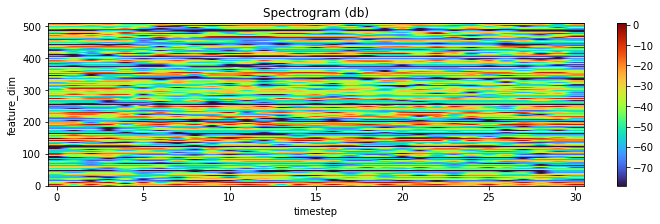

In [10]:
net = RNNExtractor(40, 512)
out_feature, out_feat_len = net(feature, feat_len)
print(out_feature.shape, out_feat_len)
plot_spectrogram(out_feature[0].transpose(0, 1).detach(), xlabel='timestep', ylabel='feature_dim')

### Classifier

torch.Size([2, 8, 1024]) tensor([32,  7])


/home/xunwei/miniconda3/envs/asr/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


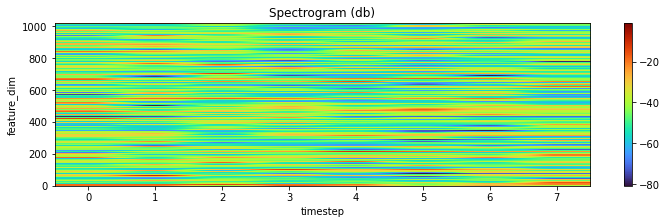

In [11]:
input_dim = out_feature.shape[2] # get input_dim from out_dim of extractor
net = RNNLayer(input_dim=input_dim, module='RNN', dim=512, bidirection=True, dropout=0.2, layer_norm=False, sample_rate=4, sample_style='drop', proj=True)
clf_out_feature, clf_out_feat_len = net(out_feature, out_feat_len)
print(clf_out_feature.shape, clf_out_feat_len)
plot_spectrogram(clf_out_feature[0].transpose(0, 1).detach(), xlabel='timestep', ylabel='feature_dim')

In [12]:
input_dim = out_feature.shape[2] # get input_dim from extractor.out_dim
print(input_dim)
net = MLPCLassfier(input_dim=input_dim)
clf_out_feature, clf_out_feat_len = net(out_feature)
print(clf_out_feature.shape, clf_out_feat_len)
# plot_spectrogram(out_feature[0].detach(), xlabel='timestep', ylabel='feature_dim')

512
torch.Size([31, 4096]) tensor([[ 0.0167, -0.0091,  0.0077,  ...,  0.0193, -0.0162, -0.0075],
        [ 0.0155, -0.0131,  0.0042,  ...,  0.0250, -0.0271, -0.0007],
        [ 0.0205, -0.0043,  0.0134,  ...,  0.0232, -0.0140, -0.0020],
        ...,
        [ 0.0136, -0.0215, -0.0006,  ...,  0.0218, -0.0335, -0.0051],
        [ 0.0143, -0.0210,  0.0193,  ...,  0.0191, -0.0316, -0.0090],
        [ 0.0099, -0.0223,  0.0057,  ...,  0.0155, -0.0322, -0.0083]],
       grad_fn=<UnbindBackward>)


## Model Summary

In [13]:
import sys
sys.path.append('../')
from src.extractor import *
from src.module import *
from torchinfo import summary

feat_len = torch.tensor([523, 123])
waveform_trans = waveform_trans
feature = torch.stack((waveform_trans, waveform_trans),dim=0)
feature.shape

torch.Size([2, 125, 40])

In [14]:
model = ANNExtractor(40)
summary(model, input_data=[feature, feat_len])

Layer (type:depth-idx)                   Output Shape              Param #
ANNExtractor                             --                        --
├─Sequential: 1-1                        [2, 40, 31, 10]           --
│    └─Conv2d: 2-1                       [2, 40, 124, 40]          400
│    └─BatchNorm2d: 2-2                  [2, 40, 124, 40]          80
│    └─ReLU: 2-3                         [2, 40, 124, 40]          --
│    └─MaxPool2d: 2-4                    [2, 40, 62, 20]           --
│    └─Conv2d: 2-5                       [2, 40, 62, 20]           14,440
│    └─MaxPool2d: 2-6                    [2, 40, 31, 10]           --
├─Sequential: 1-2                        [2, 40, 31, 10]           --
│    └─AttentionConv: 2-7                [2, 40, 31, 10]           --
│    │    └─Conv2d: 3-1                  [2, 40, 31, 10]           1,600
│    │    └─Conv2d: 3-2                  [2, 40, 37, 16]           1,600
│    │    └─Conv2d: 3-3                  [2, 40, 37, 16]           1,600
│

```
ANN
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
ANNExtractor                             --                        --
├─Sequential: 1-1                        [2, 40, 124, 40]          --
│    └─Conv2d: 2-1                       [2, 40, 124, 40]          40
│    └─ReLU: 2-2                         [2, 40, 124, 40]          --
├─Sequential: 1-2                        [2, 40, 62, 20]           --
│    └─AttentionConv: 2-3                [2, 40, 124, 40]          --
│    │    └─Conv2d: 3-1                  [2, 40, 124, 40]          1,600
│    │    └─Conv2d: 3-2                  [2, 40, 130, 46]          1,600
│    │    └─Conv2d: 3-3                  [2, 40, 130, 46]          1,600
│    └─ReLU: 2-4                         [2, 40, 124, 40]          --
│    └─MaxPool2d: 2-5                    [2, 40, 62, 20]           --
├─Sequential: 1-3                        [2, 64, 31, 10]           --
│    └─Conv2d: 2-6                       [2, 64, 62, 20]           2,560
│    └─MaxPool2d: 2-7                    [2, 64, 31, 10]           --
==========================================================================================
Total params: 7,400
Trainable params: 7,400
Non-trainable params: 0
Total mult-adds (M): 60.89
==========================================================================================
Input size (MB): 0.04
Forward/backward pass size (MB): 15.27
Params size (MB): 0.03
Estimated Total Size (MB): 15.34
==========================================================================================
```

In [15]:
model = VGGExtractor(40)
summary(model, input_data=[feature, feat_len])

Layer (type:depth-idx)                   Output Shape              Param #
VGGExtractor                             --                        --
├─Sequential: 1-1                        [2, 128, 31, 10]          --
│    └─Conv2d: 2-1                       [2, 64, 124, 40]          640
│    └─ReLU: 2-2                         [2, 64, 124, 40]          --
│    └─Conv2d: 2-3                       [2, 64, 124, 40]          36,928
│    └─ReLU: 2-4                         [2, 64, 124, 40]          --
│    └─MaxPool2d: 2-5                    [2, 64, 62, 20]           --
│    └─Conv2d: 2-6                       [2, 128, 62, 20]          73,856
│    └─ReLU: 2-7                         [2, 128, 62, 20]          --
│    └─Conv2d: 2-8                       [2, 128, 62, 20]          147,584
│    └─ReLU: 2-9                         [2, 128, 62, 20]          --
│    └─MaxPool2d: 2-10                   [2, 128, 31, 10]          --
Total params: 259,008
Trainable params: 259,008
Non-trainable params: 0

### Classifier

In [16]:
model = RNNLayer(input_dim=out_feature.shape[2], module='RNN', dim=512, bidirection=True, dropout=0.2, layer_norm=False, sample_rate=4, sample_style='drop', proj=True)
summary(model, input_data=[out_feature, out_feat_len])
print(model)

RNNLayer(
  (layer): RNN(512, 512, batch_first=True, bidirectional=True)
  (dp): Dropout(p=0.2, inplace=False)
  (pj): Linear(in_features=1024, out_features=1024, bias=True)
)


In [17]:
model = MLPCLassfier(out_feature.shape[2])
summary(model, input_data=[out_feature])

Layer (type:depth-idx)                   Output Shape              Param #
MLPCLassfier                             --                        --
├─Sequential: 1-1                        [2, 31, 4096]             --
│    └─Linear: 2-1                       [2, 31, 1024]             525,312
│    └─ReLU: 2-2                         [2, 31, 1024]             --
│    └─Linear: 2-3                       [2, 31, 2048]             2,099,200
│    └─ReLU: 2-4                         [2, 31, 2048]             --
│    └─Linear: 2-5                       [2, 31, 2048]             4,196,352
│    └─ReLU: 2-6                         [2, 31, 2048]             --
│    └─Linear: 2-7                       [2, 31, 2048]             4,196,352
│    └─ReLU: 2-8                         [2, 31, 2048]             --
│    └─Linear: 2-9                       [2, 31, 4096]             8,392,704
Total params: 19,409,920
Trainable params: 19,409,920
Non-trainable params: 0
Total mult-adds (M): 38.82
Input size (MB): 